# Dividend-Only Heterogeneous-Agent Asset Pricing 


Let's define the simplest possible asset-pricing agent. We will strip away as much as possible until we have the most basic agent, and then use that agent to incrementally explore a number of possible feedback mechanisms which may be quite important in "highly heterogeneous"-agent general equilibrium. These will include:

* differences in wealth levels
* differences in income processes (due to differing ideosyncratic shocks)
* differences in beliefs
* differences in learning mechanisms and/or experience 
* differences in preferences, including risk aversion and time discounting
* differences in portfolio allocations or policy functions due to heuristics

These are roughly in order of "palatability" -- while few people will disagree that differences in wealth levels are important, it becomes harder to measure (and justify) differences further down the list, such as differences in preferences or heuristics. 

The most basic asset pricing model will allow us to think about the effects of heterogeneity in the above characteristics easily, before moving to more complicated situations. 

In addition, solving the simplest model first will provide us a foundation against which to test more complex models to look for bugs and coding errors. This second usage will become more apparent as we progress. 

For simplicity of exposition we will use a two-period model to begin. Under a number of circumstances, the infinite-period model collapses to the two period model for optimization purposes. We will explore this in detail much later. 

## The Agent Problem

We will employ the two-period basic asset pricing problem from the first chapter of Cochrane (2001):

$$
\begin{aligned}
\underset{\xi_2}{\mathrm{max}} & \;\; u(c_{1})  + \beta \mathbb{E}\left[u(c_{2})\right] \\
c_1 & = \xi_1 d_1 + (\xi_1 - \xi_2)p_1 \\ 
c_{2} & = \xi_2 d_2 \\
c_{t} & \ge 0 \forall t \\
\xi_{t+1} & \ge -\xi_{t} \forall t
\end{aligned}
$$


The agent in question begins period 1 with an endowment of the single risky asset available in the economy, $\xi_1$, which has already realized divided $d_1$ before the period began. Thus the income indowment for the agent at the beginning of period 1 is $\xi_1 d_1$.


To solve the problem substitute the constraints into the objective, take first derivative and set to zero to find the Euler. We arive at the familiar expression:

$$
\begin{aligned}
u'(c_1)p_1 = \beta \mathbb{E}\left[u'(c_{2}) d_2 \right]
\end{aligned}
$$

For CRRA utility this is straightforward to solve algebraically for $\xi_2$:


Log CRRA:

$$
\begin{aligned}
\tilde{\xi_2} = \xi_1 \frac{d_1+p_1}{p_1} \frac{\beta}{1 + \beta}
\end{aligned}
$$


Non-Log CRRA:

$$
\begin{aligned}
\tilde{\xi_2}  = \frac{\xi_1 (d_1 + p_1)}{\left( \frac{\beta}{p_1} \mathbb{E}\left[ d_2^{1-\rho} \right] \right)^{-1/\rho} + p_1}
\end{aligned}
$$

Note that the solutions simply tie the choice $\xi_2$ to already known values and the expected values of $d_2$ at time 2.

The tilde "~" above the the demand indicates that this is unrestricted demand -- we impose the two constraints as follows:

$$
\begin{aligned}
\xi_2 = \min(\xi_1 + \frac{\xi_1 d_1}{p_1}, \max(\tilde{\xi_2}, 0.0))
\end{aligned}
$$


We can examine these two demand functions easily:



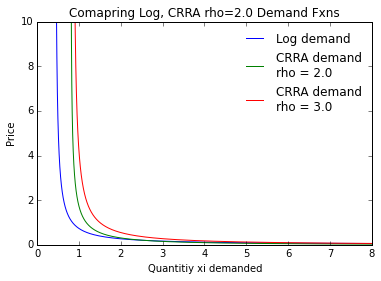

In [1]:
%matplotlib inline
from __future__ import division
import pylab as plt
import numpy as np


# Parameters:
beta = 0.99
rho = 2.0
rho3 = 3.0
xi1 = 0.85
d1 = 1.0
y0=1.0
xi0=1.0

D_vals = np.array([0.01, 0.7, 1.2, 1.7, 1.99])
D_probs = np.array([0.5, 3.0, 5.0, 3.0, 0.5])

# Normalize D_probs...
D_probs = D_probs/float(np.sum(D_probs))


# Define two demand functions:
def log_demand_Tm1(xi1, d1, p1, beta):
    xi2 = ((xi1 * d1) / p1 + xi1) * beta/(1.0 + beta)
    return max( min(xi1 + xi1*d1/p1, xi2), 0.0)

def crra_demand_Tm1(xi1, d1, p1, beta, rho, D_vals, D_probs):
    xi2  = xi1 * (d1 + p1) / ( ((beta / p1) * np.dot(D_vals**(1.0-rho), D_probs) )**(-1.0/rho) + p1)
    return max( min(xi1 + xi1*d1/p1, xi2), 0.0)





# Define some prices:
prices = np.linspace(0.01,10,1000)


log_demands = []
crra_demands = []
crra_demands_rho3 = []

for p1 in prices:
    log_demands.append( log_demand_Tm1(xi1, d1, p1, beta) )
    crra_demands.append( crra_demand_Tm1(xi1, d1, p1, beta, rho, D_vals, D_probs))
    crra_demands_rho3.append( crra_demand_Tm1(xi1, d1, p1, beta, rho3, D_vals, D_probs))

# Plot against prices:
plt.plot(log_demands, prices, label="Log demand")
plt.plot(crra_demands, prices, label="CRRA demand\nrho = "+str(rho))
plt.plot(crra_demands_rho3, prices, label="CRRA demand\nrho = "+str(rho3))
plt.xlabel("Quantitiy xi demanded")
plt.ylabel("Price")
plt.xlim([0.0, 8.0])
plt.legend(loc='best', frameon=False)
plt.title("Comparing Log, CRRA rho="+str(rho)+" Demand Fxns")
plt.show()


If we define multiple agents who have these demand functions, then finding aggregate demand is simple: for ay price, sum across all agents demand at that price. 

Note that this approach allows us to inject potentially complicated balance sheet dynamics into demand. For example, if an agent was borrowing on collateral and the value of collateral dropped, the agent may need to suddenly switch from buying to selling an asset. This might create "kinks" in the aggregate demand curve. We will explore this with a few examples below. 


Finding price with these agents is now straightforward -- define a supply for every price (could be fixed total supply) and then numerically find the price which clears the market, 

